# Trajectory inference using Slingshot

Please, save the anndata object as follows

```
adata_count = anndata.AnnData(X=np.expm1(adata.raw.X), var=adata.raw.var, obs=adata.obs, asview=False) # if adata.raw is log
```

or

```
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False) # if adata.raw is not log
```

```
sc.pp.filter_genes(adata_count, min_cells=3)
adata_count.write('data/anndata_forSeurat.h5ad')
```


In [34]:
# If problems installing slingshot
# sudo apt-get update
# sudo apt-get install libglu1-mesa-dev 
# sudo apt-get install freeglut3-dev
# sudo apt-get install mesa-common-dev
# then
# install.packages("rgl")
# BiocManager::install("slingshot")
library(Seurat)
library(dplyr)
library(slingshot)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(gam)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)

In [35]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/jovyan/my-conda-envs/R4/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] cowplot_1.0.0      pheatmap_1.0.12    ggplot2_3.3.0      harmony_1.0       
 [5] Rcpp_1.0.4.6       gam_1.16.1         foreach_1.5.0      destiny_3.2.0     
 [9] RColorBrewer_1.1-2 slingshot_1.6.0    princurve_2.1.4    dplyr_0.8.5       
[13] Seurat_3.1.5      

loaded via a namespace (

In [36]:
#### set enviroment
home = '~/farm/endometrium/data/scATAC/'
setwd(home)
outdir = paste0(home, 'seurat.output-S2/')
system(paste0('mkdir -p ', outdir, '/data'))
system(paste0('mkdir -p ', outdir, '/trajectories'))
#### 


# Load processed ATAC

In [37]:
### Load data
so = readRDS(file = paste0(outdir, '/data/M0_preintegration_noclipped.rds'))

# Slingshot

In [38]:
names(so@meta.data)

[1] "orig.ident"                       "nCount_peaks"                    
 [3] "nFeature_peaks"                   "total"                           
 [5] "duplicate"                        "chimeric"                        
 [7] "unmapped"                         "lowmapq"                         
 [9] "mitochondrial"                    "passed_filters"                  
[11] "cell_id"                          "is__cell_barcode"                
[13] "TSS_fragments"                    "DNase_sensitive_region_fragments"
[15] "enhancer_region_fragments"        "promoter_region_fragments"       
[17] "on_target_fragments"              "blacklist_region_fragments"      
[19] "peak_region_fragments"            "peak_region_cutsites"            
[21] "cell_id_cellranger"               "sample"                          
[23] "treatment"                        "day"                             
[25] "inhibitor"                        "cellatac_win_cluster"            
[27] "donor"                            "peaks_snn_res.0.65"              
[29] "seurat_clusters"                  "clusters"                        
[31] "peaks_snn_res.0.5"                "peaks_snn_res.0.6"               
[33] "peaks_snn_res.0.7"

In [39]:
# Filter HVGs and conver to SingleCellExperiment 
sce <- as.SingleCellExperiment(so)

In [40]:
# ?slingshot

In [41]:
## Run slingshot
# Slingshot is a two step process 
# 1) identifying the global lineage structure with a cluster-based minimum spanning tree (MST) and 
# 2) fitting simultaneous principal curves to describe each lineage.
# Inputs: a reduced dimensional matrix of coordinates and a set of cluster labels.
slingshot_anndata <- slingshot(sce, clusterLabels = 'seurat_clusters', reducedDim = 'UMAP', start.clus = '9')
SlingshotDataSet(slingshot_anndata)
saveRDS(slingshot_anndata, file = paste0(outdir, '/data/slingshot.rds') )

Using full covariance matrix

Warning message in if (class(X) == "dist") X <- as.matrix(X):
“the condition has length > 1 and only the first element will be used”


class: SlingshotDataSet 

 Samples Dimensions
   14026          2

lineages: 5 
Lineage1: 9  12  4  1  5  0  11  
Lineage2: 9  12  4  1  7  3  
Lineage3: 9  12  4  1  7  2  
Lineage4: 9  12  4  1  7  8  
Lineage5: 9  12  4  10  6  

curves: 5 
Curve1: Length: 13.246	Samples: 6430.04
Curve2: Length: 17.043	Samples: 6026.99
Curve3: Length: 17.252	Samples: 6037.9
Curve4: Length: 18.118	Samples: 6163.12
Curve5: Length: 13.682	Samples: 4492.04

In [42]:
# slingshot_anndata = readRDS(file = '~/farm/endometrium/figures_both_organoid/slingshot.rds')

In [49]:
colors =  c('0'='#edebaf',
                  '1'='#eb054d', 
                  '2'='#9bb9e8', 
                  '3'='#d4878a',
                  '4'= '#de5fad',
                  '5'= '#ffb5b7',
                  '6'='#9e1993',
                  '7'='#6284e3',
                  '8'='#688a12', 
                  '9'='#ba93ab',
                  '10'='#c2d986', 
                  '11'='#73346d',
                  '12'='#83346d'
)

class: SlingshotDataSet 

 Samples Dimensions
   14026          2

lineages: 5 
Lineage1: 9  12  4  1  5  0  11  
Lineage2: 9  12  4  1  7  3  
Lineage3: 9  12  4  1  7  2  
Lineage4: 9  12  4  1  7  8  
Lineage5: 9  12  4  10  6  

curves: 5 
Curve1: Length: 13.246	Samples: 6430.04
Curve2: Length: 17.043	Samples: 6026.99
Curve3: Length: 17.252	Samples: 6037.9
Curve4: Length: 18.118	Samples: 6163.12
Curve5: Length: 13.682	Samples: 4492.04

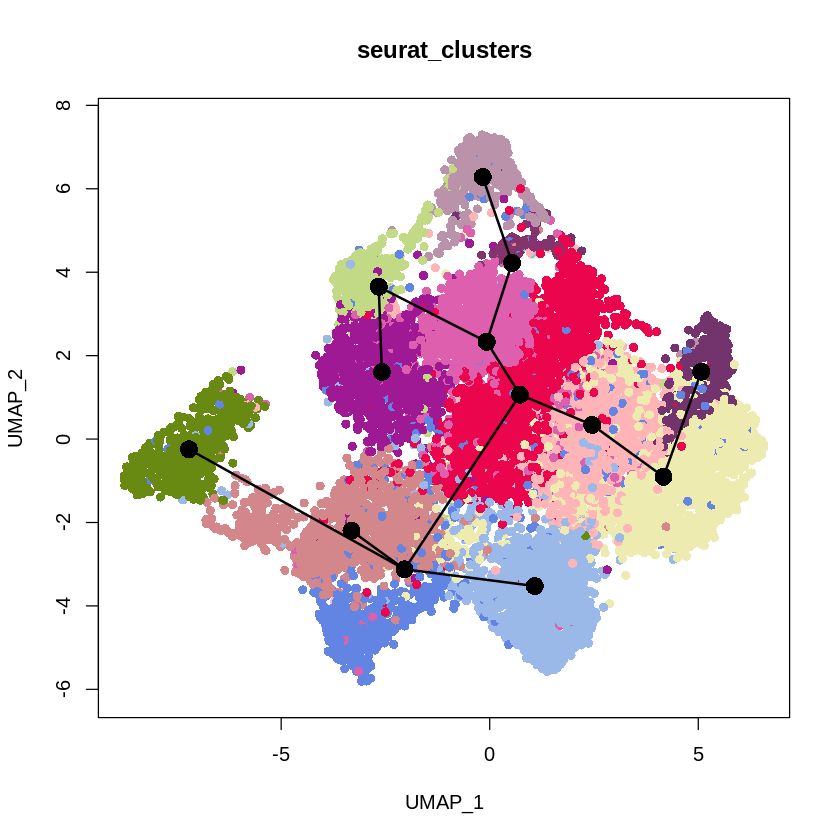

In [50]:
# See how the lineage structure was estimated by the cluster-based minimum spanning tree
# pdf(file = paste0(outdir, '/general/umap_slingshot.pdf'))
plot(reducedDims(slingshot_anndata)$UMAP, col = colors[as.numeric(slingshot_anndata$seurat_clusters)], pch=16, asp = 1, main = 'seurat_clusters')
lines(SlingshotDataSet(slingshot_anndata), lwd=2, type = 'lineages', col = 'black')
# dev.off()
SlingshotDataSet(slingshot_anndata)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   4.729   7.400   7.377  10.247  13.246    6519 

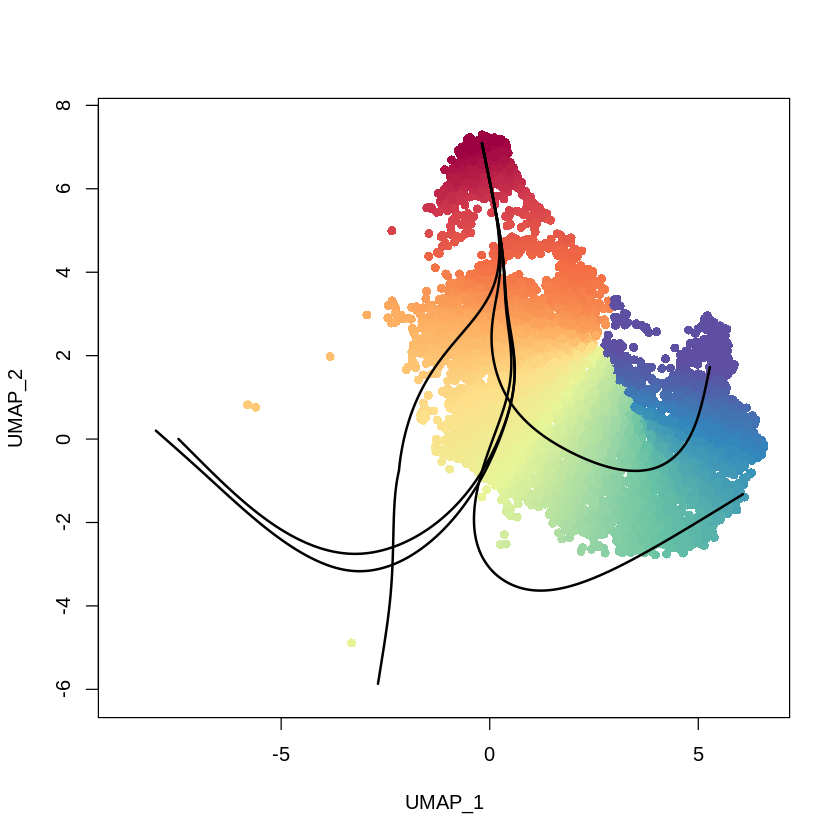

In [45]:
# Visualize the lineage 1
summary(slingshot_anndata$slingPseudotime_1)
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(slingshot_anndata$slingPseudotime_1, breaks=100)]
plot(reducedDims(slingshot_anndata)$UMAP, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(slingshot_anndata), lwd=2, col='black')

# DEGs in lineages

In [ ]:
### DEGs over time
SlingshotDataSet(slingshot_anndata)
lineages = grep(names(slingshot_anndata@colData), pattern = 'slingPseudotime_', value = T)

In [ ]:
# Working on lineage 1
lineage_index = 1

In [ ]:
# Filter object to contain only 1 lineage
clusters_in_lineage = SlingshotDataSet(slingshot_anndata)@lineages[[lineage_index]]
cells_in_lineage = which(as.character(slingshot_anndata@colData$seurat_clusters) %in% clusters_in_lineage)
lineage_slingshot = slingshot_anndata[, cells_in_lineage]

In [ ]:
# Extract time and gene expression values (scaled)
t <- lineage_slingshot@colData[, lineages[lineage_index] ]
Y <- subset(so, cells = rownames(slingshot_anndata@colData)[cells_in_lineage] )@assays$RNA@scale.data

In [ ]:
all(rownames(lineage_slingshot@colData) == colnames(Y))
Y = Y[, !is.na(t)]
t = t[!is.na(t)]

In [ ]:
# For time effiency, only test the most variable genes
# Downsample clusters to ensure even representation of all the stages
sampling = list()
for (i in 1:100){
  random_cells = lapply(clusters_in_lineage, function(cl) sample(colnames(lineage_slingshot)[ lineage_slingshot$seurat_clusters == cl], size = 50, replace = T)  )
  random_cells = unlist(random_cells) %>% unique(.)
  var100 = VariableFeatures(FindVariableFeatures(subset(so, cells = random_cells), nfeatures = 1000)) #head(names(sort(apply(Y[, random_cells],1,var),decreasing = TRUE)), n=1000)
  sampling[[i]] = var100
}
table(unlist(sampling))[ known_genes ]
frequent_genes = names(which(table(unlist(sampling)) > 90 ))
# Remove mito and ribo genes
frequent_genes = grep('^MT-', frequent_genes, value = T, invert = T)
frequent_genes = grep('^RPS', frequent_genes, value = T, invert = T)
frequent_genes = grep('^RPL', frequent_genes, value = T, invert = T)
intersect(frequent_genes, known_genes)
length(frequent_genes)
frequent_genes = unique(c(frequent_genes, 'LGR6'))

In [ ]:
frequent_genes = intersect(frequent_genes, rownames(Y))
Y <- Y[frequent_genes,]
intersect(frequent_genes, known_genes)

In [ ]:
# fit a GAM with a loess term for pseudotime
gam_test  <- apply(Y,1,function(z){
  d <- data.frame(z=z, t=t)
  suppressWarnings({
    tmp <- suppressWarnings(gam(z ~ lo(t), data=d))
  })
  p <- c(tmp$coefficients[2], # statistic
         summary(tmp)[3][[1]][2,3]) # pvalue
  p
})

In [ ]:
## Visualize
# pick out the top genes based on p-value and statistic
gam.stat = gam_test[1,]
gam.pval = gam_test[2,]
gam_test[, colnames(gam_test) %in% known_genes]
gam_test_sign = gam_test[ , gam.pval <= 1e-6  ]
topgenes <- names(which(abs(gam.stat) > 0.05))
intersect(topgenes, known_genes)
length(topgenes)

In [ ]:
# prepare data for plotting
# order genes expression over lineage pseudotime with a heatmap
heatdata <- Y[ topgenes, order(t, na.last = NA)]
# order seurat_clusters ids as well
heatclus <- lineage_slingshot$seurat_clusters[order(t)]
#heatmap(as.matrix(heatdata), Colv = NA, scale = 'none', ColSideColors = brewer.pal(9,"Set1")[heatclus+1])
annotation_col = as.data.frame(as.factor(heatclus))
rownames(annotation_col) = colnames(lineage_slingshot)[order(t, na.last = NA)]
names(annotation_col) = 'seurat_clusters'

In [ ]:
# plot heatmap with genes sorted according their Pearson correlation
dev.off()
pdf(file = paste0('~/farm/endometrium/figures_both_organoid/slingshot_lineage', lineage_index,'.pdf'), height = 10)
out = pheatmap(as.matrix(heatdata),  scale = 'none', 
#                color = colorRampPalette(c("white", "firebrick3"))(50),
               clustering_distance_rows= "correlation", cutree_rows = 7,
               annotation_col = annotation_col, show_colnames = F, cluster_cols=F, 
               fontsize_row = 6)
dev.off()
out

In [ ]:
# Group genes in cluster for gene set enrichment
# Extract gene groups from the previous gene dendogram
gene_clusters = as.data.frame(sort(cutree(out$tree_row, k=7)))
names(gene_clusters) = 'group'
table(gene_clusters$group)
gene_clusters$group = as.factor(gene_clusters$group)
write.table(gene_clusters, file = paste0('~/farm/endometrium/figures_both_organoid/slingshot_lineage', lineage_index,'_genegroups.txt'), quote = F, sep = '\t')

In [ ]:
dev.off()
# plot heatmap again with gene_clusters labels
pdf(file = paste0('~/farm/endometrium/figures_both_organoid/slingshot_lineage', lineage_index,'_GeneClusters.pdf'), height = 10)
pheatmap(as.matrix(heatdata),  scale = 'none', 
#                color = colorRampPalette(c("white", "firebrick3"))(50),
               clustering_distance_rows= "correlation", annotation_row = gene_clusters, cutree_rows = 10,
               annotation_col = annotation_col, show_colnames = F, cluster_cols=F, 
               fontsize_row = 6)
dev.off()

### GSA on the DES along the trajectory

In [ ]:
library(piano)
library(reshape2)

In [ ]:
# Load genesets and filter those with > 2 genes in the anndata
genesets = readRDS(file = '~/farm/gsea/genesets/all_genesets.rds')
# genesetsf = lapply(genesets, intersect, allgenes)
genesetsf = lapply(genesets, intersect, rownames(so))
genesetsf = genesetsf[ sapply(genesetsf, length) > 2 ]
gsc <- loadGSC(melt(genesetsf))
background_genes = intersect(allgenes, unlist(genesetsf))

In [ ]:
gene_clusters$gene = rownames(gene_clusters)
# Compute enrichment gene_clusters
groups_of_interest = names(which(table(gene_clusters$group) >= 3))
results = list()
message('N genesets ', length(genesetsf))
message('N clusters ', length(groups_of_interest))
for ( gr in groups_of_interest ){
      print(gr)
      genes = subset(gene_clusters, group == gr)$gene
      x  = runGSAhyper(genes, gsc = gsc, universe = setdiff(background_genes, genes), gsSizeLim = c(3, 500))
      ORx = sapply(x$contingencyTable, function (ct) (ct[1,1]*ct[2,2]) / (ct[1,2]*ct[2,1]) )
      sig_idx =  which(x$pvalues < 0.001)
      if(sum(x$pvalues < 0.001) >  1){
        results[[gr]]  = data.frame(x$resTab[sig_idx, 1:4], OR= ORx[ sig_idx ], gr = gr, genes = paste(genes, collapse = ','))
        results[[gr]]$term = names(x$gsc)[ sig_idx ]
      }
      if(sum(x$pvalues < 0.001) ==  1){
        results[[gr]]  = data.frame(t(x$resTab[ sig_idx, 1:4]), OR= ORx[ sig_idx ], gr = gr, genes = paste(genes, collapse = ','))
        results[[gr]]$term = names(x$gsc)[ sig_idx ]
      }
}

In [ ]:
# Format output
df = do.call(rbind, results)
df = df[ df$Significant..in.gene.set. >= 2 , ]
rownames(df)= NULL
write.table(df, file = paste0('~/farm/endometrium/figures_both_organoid/slingshot_lineage', lineage_index,'_genegroups_GSA.txt'), quote = F, sep = '\t')
df[ df$p.value < 0.001, c(6,1,5,8)]

In [ ]:
df$logOR = log2(df$OR)
names(df)[3] = 'N'

In [ ]:
df$term_clean = sapply(strsplit(df$term, split = "::"), head, 1)
df$term_clean = lapply(strsplit(df$term_clean, split = "_"), head, 10) %>% sapply(., paste, collapse=' ')
ggplot(df[df$p.value < 0.001, ], aes(y=term_clean, x=logOR, color = p.value, size = N) ) + geom_point() + 
    facet_grid(gr~., scales = "free_y", space = "free_y") + 
    scale_color_gradientn(colours=rainbow(2)) +
    theme(legend.position = "bottom" )
ggsave(paste0('~/farm/endometrium/figures_both_organoid/slingshot_lineage', lineage_index,'_genegroups_GSA.png'), width = 10, height = 10)